In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

# Time Series Demo

In [3]:
sales = pd.read_csv("./data/sales_train.csv")
sales.date = pd.to_datetime(sales.date, format = "%d.%m.%Y")
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [4]:
sales.shop_id.unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

In [5]:
sales.shop_id.value_counts()

shop_id
31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
21     58133
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: count, dtype: int64

In [6]:
sales[(sales.shop_id == 31) & (sales.date == "2013/07/01")]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
646788,2013-07-01,6,31,16227,419.0,2.0
646847,2013-07-01,6,31,15628,149.0,1.0
646848,2013-07-01,6,31,15634,299.0,1.0
646969,2013-07-01,6,31,16182,1299.0,1.0
646978,2013-07-01,6,31,16459,299.0,1.0
...,...,...,...,...,...,...
661445,2013-07-01,6,31,2768,849.0,1.0
661468,2013-07-01,6,31,2400,1199.0,1.0
661502,2013-07-01,6,31,2398,599.0,5.0
661529,2013-07-01,6,31,2458,299.0,2.0


In [7]:
shop_31 = sales[sales.shop_id == 31]
total_counts = shop_31.groupby("date").item_cnt_day.sum()

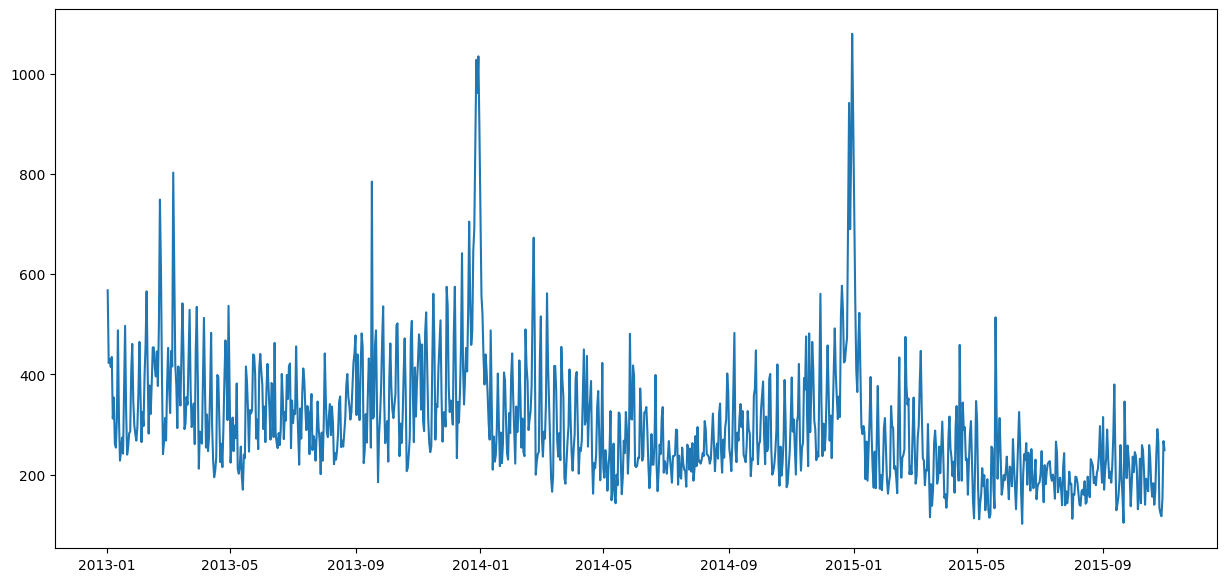

In [8]:
plt.figure(figsize=[15, 7])
plt.plot(total_counts.index, total_counts)
plt.show()

C:\Users\BOEVVBOY\AppData\Local\Temp\ipykernel_27056\2322026369.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = total_counts.resample("1M").mean()


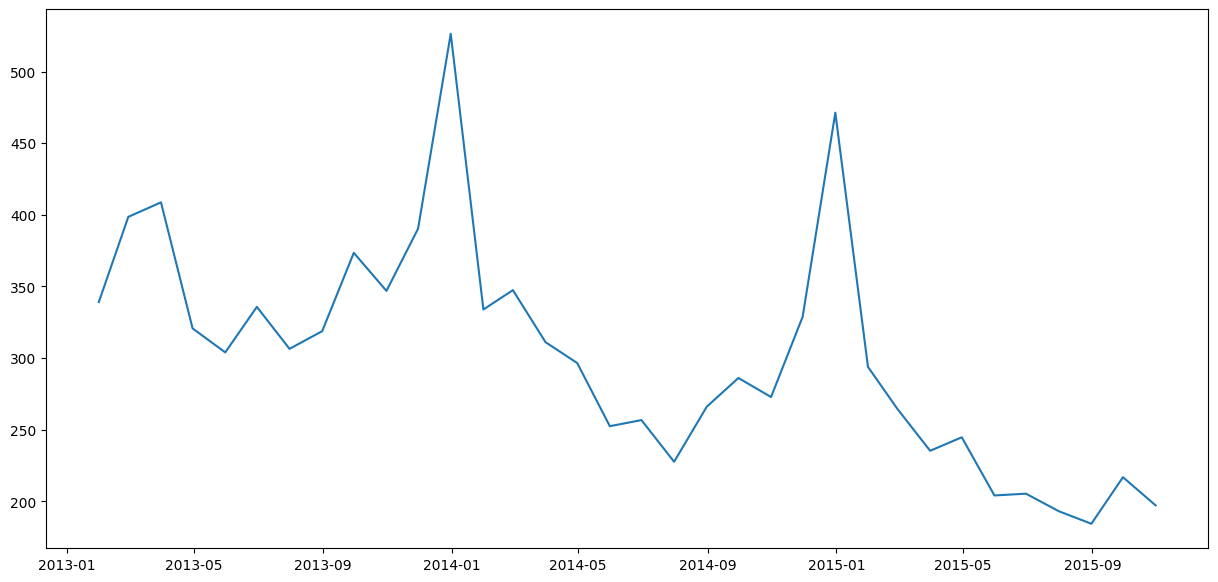

In [9]:
# monthly_means = total_counts.resample(pd.Timedelta(7, "days")).mean()
monthly_means = total_counts.resample("1M").mean()

plt.figure(figsize=[15, 7])
plt.plot(monthly_means.index, monthly_means)
plt.show()

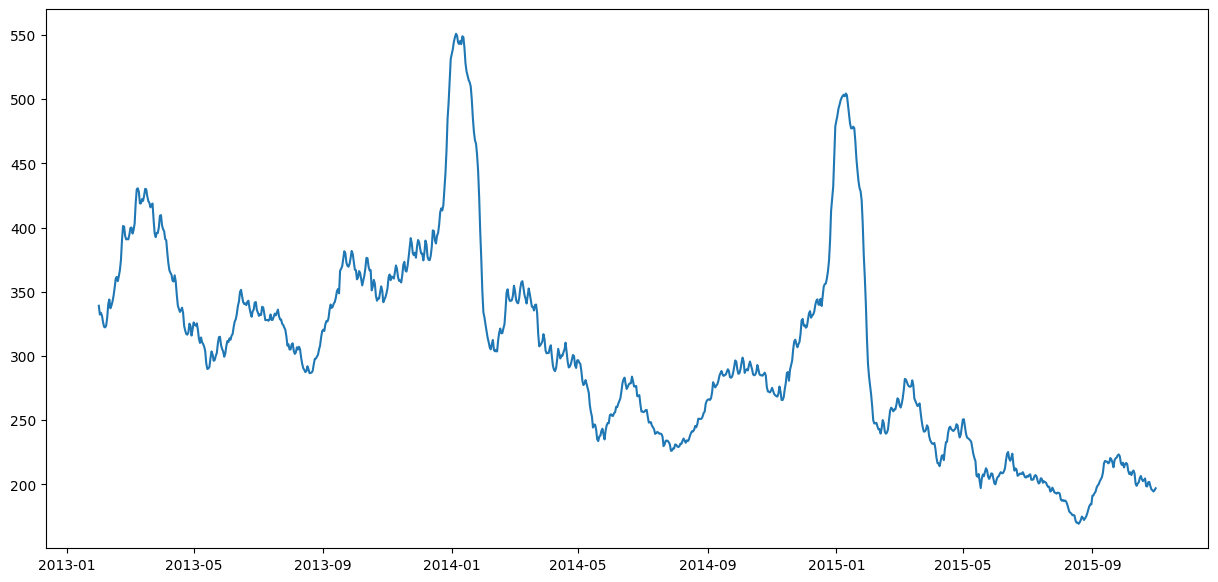

In [10]:
rolling_means  = total_counts.rolling(30).mean().dropna()

plt.figure(figsize=[15, 7])
plt.plot(rolling_means.index, rolling_means)
plt.show()

In [11]:
sales.item_id.nunique()

21807

In [12]:
shop_31 = shop_31.sort_values(["item_id", "date"]).reset_index(drop=True)
shop_31 = shop_31.drop(columns=["date_block_num"])
shop_31.item_id.value_counts()

item_id
20949    863
5822     602
17717    478
7856     436
4181     400
        ... 
10573      1
18601      1
10571      1
10568      1
26         1
Name: count, Length: 14416, dtype: int64

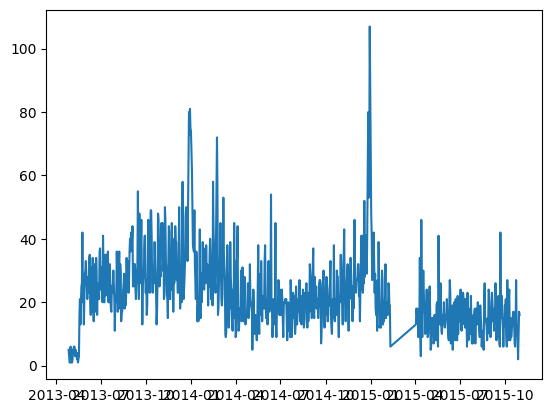

In [13]:
shop_13_item_20949 = shop_31[shop_31.item_id == 20949]
plt.plot(shop_13_item_20949.date, shop_13_item_20949.item_cnt_day)

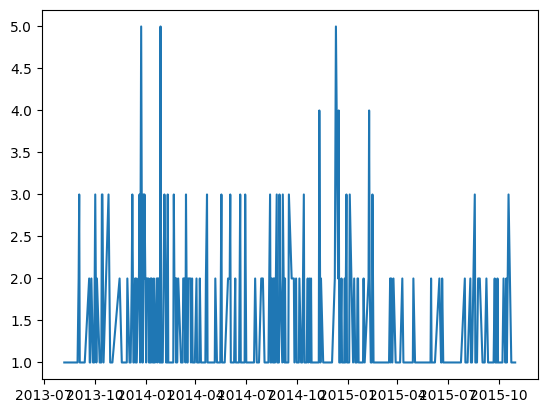

In [14]:
shop_13_item_4181 = shop_31[shop_31.item_id == 4181]
plt.plot(shop_13_item_4181.date, shop_13_item_4181.item_cnt_day)

In [15]:
shop_13_item_20949.date.diff()

224196      NaT
224197   2 days
224198   1 days
224199   1 days
224200   1 days
          ...  
225054   1 days
225055   1 days
225056   1 days
225057   1 days
225058   1 days
Name: date, Length: 863, dtype: timedelta64[ns]

In [16]:
shop_13_item_20949.item_cnt_day.diff(18)

224196     NaN
224197     NaN
224198     NaN
224199     NaN
224200     NaN
          ... 
225054   -11.0
225055   -22.0
225056    -2.0
225057     9.0
225058     1.0
Name: item_cnt_day, Length: 863, dtype: float64

In [17]:
sales = sales[:10000]
original_columns = sales.columns

for shift in range(1, 10):
    shifted = sales.shift(shift)
    shifted = shifted[original_columns].rename(columns = lambda col: f"{col}_lag_{shift}")
    sales = pd.concat([sales, shifted], axis=1)
# for diff in [1,2 ,5, 10]:

for diff in range(1, 10):
    differenced = sales.diff(diff)
    differenced = differenced[original_columns].rename(columns = lambda col: f"{col}_d_{diff}")
    sales = pd.concat([sales, differenced], axis=1)
# for diff in [1,2 ,5, 10]:
#     shop_13_item_20949[f"lag_{diff}"] = shop_13_item_20949.diff(diff)

sales = sales.dropna()

sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_lag_1,date_block_num_lag_1,shop_id_lag_1,item_id_lag_1,...,shop_id_d_8,item_id_d_8,item_price_d_8,item_cnt_day_d_8,date_d_9,date_block_num_d_9,shop_id_d_9,item_id_d_9,item_price_d_9,item_cnt_day_d_9
9,2013-01-03,0,25,2573,299.00,3.0,2013-01-11,0.0,25.0,2572.0,...,0.0,21.0,-600.00,2.0,1 days,0.0,-34.0,-19581.0,-700.00,2.0
10,2013-01-03,0,25,2574,399.00,2.0,2013-01-03,0.0,25.0,2573.0,...,0.0,22.0,-500.00,3.0,0 days,0.0,0.0,22.0,-500.00,1.0
11,2013-01-05,0,25,2574,399.00,1.0,2013-01-03,0.0,25.0,2574.0,...,0.0,20.0,-1310.05,0.0,0 days,0.0,0.0,22.0,-500.00,2.0
12,2013-01-07,0,25,2574,399.00,1.0,2013-01-05,0.0,25.0,2574.0,...,0.0,19.0,-700.00,0.0,1 days,0.0,0.0,20.0,-1310.05,0.0
13,2013-01-08,0,25,2574,399.00,2.0,2013-01-07,0.0,25.0,2574.0,...,0.0,10.0,50.00,1.0,-7 days,0.0,0.0,19.0,-700.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2013-01-16,0,18,22139,791.12,1.0,2013-01-07,0.0,18.0,22135.0,...,0.0,47.0,682.12,0.0,10 days,0.0,0.0,47.0,682.12,0.0
9996,2013-01-05,0,18,22140,499.00,1.0,2013-01-16,0.0,18.0,22139.0,...,0.0,48.0,390.00,0.0,-5 days,0.0,0.0,48.0,390.00,0.0
9997,2013-01-06,0,18,22140,349.50,1.0,2013-01-05,0.0,18.0,22140.0,...,0.0,48.0,240.50,0.0,-9 days,0.0,0.0,48.0,240.50,0.0
9998,2013-01-20,0,18,22151,399.00,1.0,2013-01-06,0.0,18.0,22140.0,...,0.0,59.0,290.00,0.0,2 days,0.0,0.0,59.0,290.00,0.0
